In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions_multi import get_angle_deviation
import os

In [2]:
data_dir = 'data/akimenko/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/akimenko/'
os.system('mkdir -p {}'.format(plot_dir))

0

In [63]:
momentum = 7.3e3 # GeV/c , 
m = 105.7 # MeV
E = np.round(np.sqrt(momentum**2 + m**2))
print('energy E = {} MeV'.format(E) )


E_i = E # momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 31125 # total measured events in akimenko
    
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 1e-3 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 1.44 # in cm

energy E = 7301.0 MeV


In [64]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Copper(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)


# collection.scattering = pp.scattering.ScatteringMultiplier(multiple_scatter, beta_multiplescatter)
# '''
collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])
# '''

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

# Run simulation

In [65]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

100%|██████████| 31125/31125 [00:01<00:00, 24500.02it/s]


In [66]:
tracks_144 = []
for track in tracks:
    if track.track_propagated_distances()[-1] == max_dist:
        tracks_144.append(track)

In [67]:
tracks_144_zenith = []
tracks_144_azimuth = []
tracks_144_x = []
tracks_144_y = []
tracks_144_z = []
tracks_144_pos_x = []
tracks_144_pos_y = []
tracks_144_pos_z = []
for track in tqdm(tracks_144):
    tracks_144_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_144_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_144_x.append(track.track_directions()[-1].x)
    tracks_144_y.append(track.track_directions()[-1].y)
    tracks_144_z.append(track.track_directions()[-1].z)
    tracks_144_pos_x.append(track.track_positions()[-1].x)
    tracks_144_pos_y.append(track.track_positions()[-1].y)
    tracks_144_pos_z.append(track.track_positions()[-1].z)

100%|██████████| 31125/31125 [00:00<00:00, 42710.96it/s]


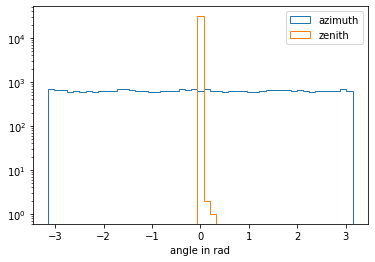

In [68]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_144_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_144_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

In [47]:
# reproduziere den plot von attwood -> irgendwie muss der winkel noch berücksichtigt werden, wie?
# lese schon mal die daten von attwood ein und erzeuge dann einen auf 100% normierten bar plot

In [48]:
# read in unfoled data of Attwood, angle in rad and probability in percent
Akimenko = pd.read_csv('data/akimenko/Akimenko_data.csv', sep=';', decimal=',', names=['angle', 'probability']) 
print('total counts akimenko: ', np.sum(Akimenko.probability))

total counts akimenko:  31129.540066072026


15840.0

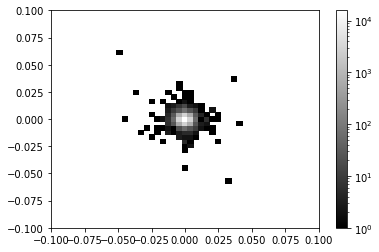

In [49]:
bins = (np.linspace(-0.1, 0.1, 50), np.linspace(-0.1, 0.1, 50))
n = plt.hist2d(tracks_144_x, tracks_144_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
plt.colorbar()
np.max(n[0])

## save data

In [69]:
# '''
df = pd.DataFrame()
df['tracks_144_x'] = tracks_144_x
df['tracks_144_y'] = tracks_144_y
df['tracks_144_z'] = tracks_144_z
df['tracks_144_pos_x'] = tracks_144_pos_x
df['tracks_144_pos_y'] = tracks_144_pos_y
df['tracks_144_pos_z'] = tracks_144_pos_z
df['tracks_144_zenith'] = tracks_144_zenith
df['tracks_144_azimuth'] = tracks_144_azimuth
key = 'E{}_{}_v_cut{}'.format(int(E_i), scattering_method, v_cut)
df.to_hdf(data_dir + 'sim_data.hdf5', key=key)
print(key)
# '''

E7301_moliere_v_cut0.001


/home/pgutjahr/proposal_7_3_0/lib64/python3.6/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'E7301_moliere_v_cut0.001'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## read data

In [70]:
key_0 = 'E7301_moliere_v_cut0.001'
df_0 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_0)
df_0.to_hdf(data_dir + 'sim_data.hdf5', key=key_0)

# key_2 = 'E199_highland_v_cut0.001'
# df_2 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_2)
# df_2.to_hdf(data_dir + 'sim_data.hdf5', key=key_2)

key_5 = 'E7301_moliere_v_cut1e-05'
df_5 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_5)
df_5.to_hdf(data_dir + 'sim_data.hdf5', key=key_5)

# key_6 = 'E199_moliere_v_cut1e-05_G4defl'
# df_6 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_6) # not relevant because there are only ionizations -> hence the
# deflection parametrization for brems and nuclint does not effect anything

key_7 = 'E7301_only_moliere_v_cut1e-05'
df_7 = pd.read_hdf(data_dir + 'sim_data.hdf5', key=key_7)

/home/pgutjahr/proposal_7_3_0/lib64/python3.6/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'E7301_moliere_v_cut1e-05'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


# Plot all 

In [37]:
# binning = [Akimenko.angle[i] - abs(Akimenko.angle[i+1] - Akimenko.angle[i])/2 for i in range(len(Akimenko)-1)]
# binning.append(Akimenko.angle.values[-1] - abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2)
# binning.append(Akimenko.angle.values[-1] + abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2)
# binning

[-0.020008250937143476,
 -0.015950487586244358,
 -0.011256689031346773,
 -0.007971423914815014,
 -0.007019408377247783,
 -0.006033064866626825,
 -0.004982173901233223,
 -0.003964762047047314,
 -0.003011558102895636,
 -0.002027455587548211,
 -0.000979790297169554,
 2.614494485790597e-06,
 0.0010479369261693905,
 0.002060085836909878,
 0.002990608192535451,
 0.004034029173683928,
 0.005026382626174825,
 0.006019890530776345,
 0.005776199272016078,
 0.008976544249470319]

In [52]:
binning = [Akimenko.angle[0] - abs(Akimenko.angle[1] - Akimenko.angle[0])/2]
binning_h = [Akimenko.angle[i] + abs(Akimenko.angle[i+1] - Akimenko.angle[i])/2 for i in range(len(Akimenko)-1)]
for b in binning_h:
    binning.append(b)
binning.append(Akimenko.angle.values[-1] + abs(Akimenko.angle.values[-1] - Akimenko.angle.values[-2])/2 )
binning

[-0.020008250937143476,
 -0.015980774976910955,
 -0.01198358640734503,
 -0.00874358260444396,
 -0.007002634867170095,
 -0.00601707230944749,
 -0.0049987436844678625,
 -0.003980992285543539,
 -0.002996040908350081,
 -0.002011802575107294,
 -0.000996394034878034,
 1.806378008366305e-05,
 0.0010313671429347526,
 0.0020435500081490768,
 0.003022627261367962,
 0.004017187754658556,
 0.005026925897756291,
 0.00602036589341012,
 0.00701482452327919,
 0.009248383767045149,
 0.012992407779649051,
 0.017008271309827787]

moliere, E = 7301.0 MeV


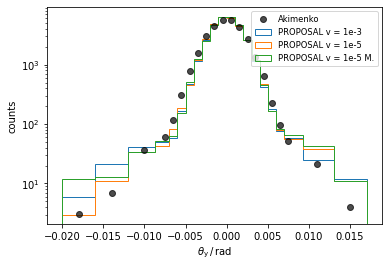

In [74]:
# plot y direction

plt.plot(Akimenko.angle, Akimenko.probability, 'o', color='black', alpha=0.7, label='Akimenko')

bins = binning
plt.hist(df_0.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-3')
plt.hist(df_5.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-5')
plt.hist(df_7.tracks_144_y, bins=bins, histtype='step', label='PROPOSAL v = 1e-5 M.') # only Molière 



plt.ylabel('counts')
# plt.xlabel('y angle in rad')
plt.xlabel(r'$\theta_{\mathrm{y}}\,/\,$rad')
plt.yscale('log')
plt.legend(loc='upper right', fontsize='small')
print('moliere, E = {} MeV'.format(E))
plt.savefig(plot_dir + 'akimenko_comparison_moliere_E7301MeV_final.pdf', bbox_inches='tight')

In [ ]:
x Achse beachten! was ist mit total scattering angle theta in dunsch gemeint???